[Titanic: Machine Learning from Disaster | Kaggle](https://www.kaggle.com/c/titanic/data)

In [124]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [125]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [126]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import re
from collections import Counter
from sklearn.preprocessing import LabelEncoder
sns.set_style('whitegrid')
sns.set_palette('Set1')

## 1 导入数据

In [127]:
datadir = 'dataset/'

In [128]:
# read data from file
train_data = pd.read_csv(f'{datadir}train.csv')
test_data = pd.read_csv(f'{datadir}test.csv')

## 2 数据基本信息

In [129]:
train_data.head()
test_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [130]:
train_data.describe()
test_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [131]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float

### 2.1 异常值检测

In [132]:
def detect_outliers(Q1, Q3, df, col):
    outlier_indices = []
    IQR = Q3 - Q1
    outlier_step = 1.5 * IQR
    outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
    outlier_indices.extend(outlier_list_col)     
    return outlier_indices

In [133]:
train_data.Age.describe()
train_data.Fare.describe()
train_data.SibSp.describe()
train_data.Parch.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

count    891.000000
mean       0.523008
std        1.102743
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        8.000000
Name: SibSp, dtype: float64

count    891.000000
mean       0.381594
std        0.806057
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.000000
Name: Parch, dtype: float64

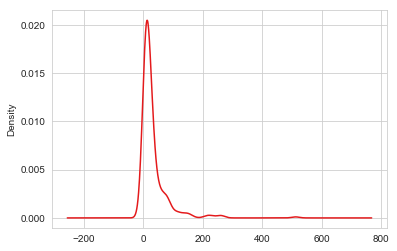

In [134]:
train_data.Fare.plot(kind='kde')

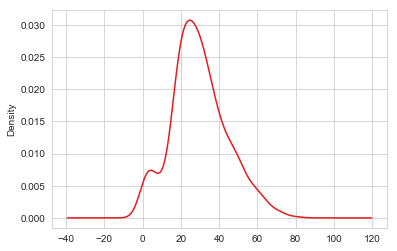

In [135]:
train_data.Age.plot(kind='kde')

In [136]:
out1 = detect_outliers(20.125, 38, train_data, 'Age')
out2 = detect_outliers(7.9, 31, train_data, 'Fare')

In [137]:
np.array(out1)
np.array(out2)

array([ 33,  54,  96, 116, 280, 456, 493, 630, 672, 745, 851])

array([  1,  27,  31,  34,  52,  61,  62,  72,  88, 102, 118, 120, 124,
       139, 151, 159, 180, 195, 201, 215, 218, 224, 230, 245, 256, 257,
       258, 262, 268, 269, 275, 290, 291, 297, 299, 305, 306, 307, 310,
       311, 318, 319, 324, 325, 332, 334, 336, 337, 341, 366, 369, 373,
       375, 377, 380, 385, 390, 393, 412, 435, 438, 445, 453, 484, 486,
       496, 498, 504, 505, 520, 527, 537, 540, 544, 550, 557, 558, 581,
       585, 587, 591, 609, 627, 641, 645, 655, 659, 660, 665, 679, 681,
       689, 698, 700, 708, 716, 730, 737, 741, 742, 745, 759, 763, 765,
       779, 789, 792, 802, 820, 829, 835, 846, 849, 856, 863, 879])

Fare分布不均衡，去掉一部分过大的Fare，怀疑其可能是离群值

In [138]:
train_data.loc[out2]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C
34,35,0,1,"Meyer, Mr. Edgar Joseph",male,28.0,1,0,PC 17604,82.1708,NaN,C
52,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0000,B28,NaN
62,63,0,1,"Harris, Mr. Henry Birkhardt",male,45.0,1,0,36973,83.4750,C83,S
72,73,0,2,"Hood, Mr. Ambrose Jr",male,21.0,0,0,S.O.C. 14879,73.5000,NaN,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.0000,C23 C25 C27,S
102,103,0,1,"White, Mr. Richard Frasar",male,21.0,0,1,35281,77.2875,D26,S


有多个 512值，暂时不认为其实离群值

In [139]:
# 备份数据
# 因为要做一些统一处理，所以将训练集测试集拼接起来
train = train_data
test = test_data
all_data = pd.concat([train, test], axis=0, sort=False, ignore_index=True)

In [140]:
train.shape, test.shape, all_data.shape

((891, 12), (418, 11), (1309, 12))

In [141]:
# one-hot编码
def dummies(col,data):
    data_dum = pd.get_dummies(data[col])
    data = pd.concat([data, data_dum], axis=1)
    data.drop(col, axis=1, inplace=True)
    return data
le = LabelEncoder()

## 3 分类变量分析

In [142]:
# 获取所有的列名
all_data.columns.tolist()

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

数据总共有12个变量，其中PassengerId、Survived两个变量分别是样本编号和预测目标，这里暂时不考虑。由于test数据集在应用最终模型的过程之前都是未知的，所以，这里主要分析train，之后将相同的预处理操作应用到test，以保证模型的泛化能力。

### 3.1 Pclass

In [143]:
train.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

Pclass一共有三种数值，其中Pclass3的人数最多

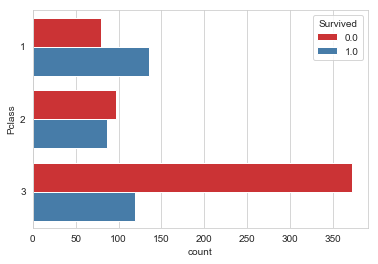

In [144]:
sns.countplot(y='Pclass', hue='Survived', data=all_data)

上图可以看出：Pclass=1的乘客中，存活的数量明显大于死亡的人数，而Pclass=2的乘客生存和死亡的数量大致是相当的，Pclass=3的乘客死亡的人数占多数；这充分说明Pclass对最终的预测有很大的影响，是一个重要的特征。

In [145]:
any(all_data.Pclass.isna())

False

In [146]:
all_data.Pclass.head()

0    3
1    1
2    3
3    1
4    3
Name: Pclass, dtype: int64

In [147]:
# all_data = dummies('Pclass', all_data)
all_data['Pclass'] = le.fit_transform(all_data['Pclass'])

In [148]:
all_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,2,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,2,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,2,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [149]:
# all_data.rename(columns={1: 'Pclass1', 2: 'Pclass2', 3: 'Pclass3'}, inplace=True)

In [150]:
all_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,2,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,2,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,2,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [151]:
backup1 = all_data
train = all_data[:891]
test = all_data[-418:]

### 3.2 Name

In [152]:
# 恢复数据
all_data = backup1

In [153]:
any(all_data.Name.isna())

False

In [154]:
all_data.Name.head(10)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

名字中最有用的信息就是称呼，例如Mrs. 鸟事已经结婚的太太, Miss 表示未结婚的年轻女子，Master表示研究生等，社会地位的高低可能会影响最终的生存情况。首先，将称呼提取出来，然后观察是否与生存有关。

In [155]:
title = all_data.Name.map(lambda x: re.compile(",(.*?)\.").findall(x)[0].strip())

In [156]:
title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [157]:
# 将 title 添加到最后
all_data['Title'] = title
all_data.drop('Name', axis=1, inplace=True)

In [158]:
all_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0.0,2,male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1.0,0,female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1.0,2,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1.0,0,female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0.0,2,male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [159]:
backup2 = all_data
train = all_data[:891]
test = all_data[-418:]

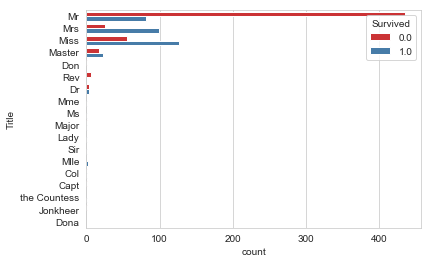

In [160]:
sns.countplot(y='Title', hue='Survived', data=all_data)

In [161]:
all_data.Title.value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Mlle              2
Ms                2
Major             2
Sir               1
Capt              1
Don               1
Lady              1
Dona              1
the Countess      1
Mme               1
Jonkheer          1
Name: Title, dtype: int64

这里有法语有英语，我们统一为英语并且合并数量较少的类别:
* Mlle, Lady, Jonkheer, Dona --> Other
* Mme --> Other
* Don, Sir, Rev, Col --> Other
* Ms --> Other
* Major, Master, Dr, the Countess, Capt --> High

In [162]:
all_data.Title.replace({'Mlle': 'Other', 'Lady': 'Other', 'Dona': 'Other', 'Jonkheer': 'Other', 'Mme': 'Other', 
                        'Don': 'Other', 'Sir': 'Other', 'Rev': 'Other', 'Col': 'Other', 'Major': 'High', 'Ms': 'Other',
                        'Master': 'High', 'Dr': 'High', 'the Countess': 'High', 'Capt': 'High'}, inplace=True)

In [163]:
all_data.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'High', 'Other'], dtype=object)

In [164]:
all_data.Title.value_counts()

Mr       757
Miss     260
Mrs      197
High      73
Other     22
Name: Title, dtype: int64

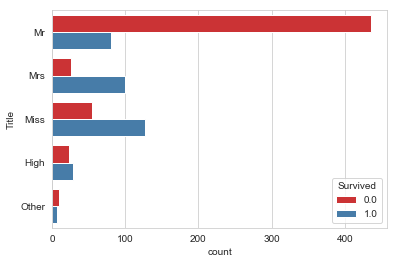

In [165]:
sns.countplot(y='Title', hue='Survived', data=all_data)

最终只留下四个类别，这些特征可能与性别存在冲突

In [166]:
# all_data = dummies('Title', all_data)
all_data['Title'] = le.fit_transform(all_data['Title'])

In [167]:
backup2 = all_data

### 3.3 Sex

In [168]:
all_data = backup2

In [169]:
any(all_data.Sex.isna())

False

In [170]:
all_data.Sex.value_counts()

male      843
female    466
Name: Sex, dtype: int64

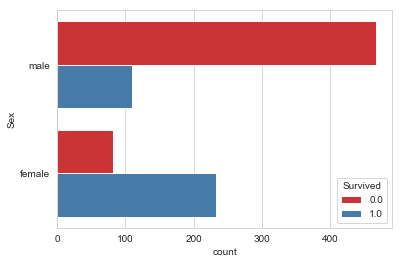

In [171]:
sns.countplot(y='Sex', hue='Survived', data=all_data)

In [172]:
# all_data = dummies('Sex', all_data)
all_data['Sex'] = le.fit_transform(all_data['Sex'])

In [173]:
all_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0.0,2,1,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1.0,0,0,38.0,1,0,PC 17599,71.2833,C85,C,3
2,3,1.0,2,0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1.0,0,0,35.0,1,0,113803,53.1000,C123,S,3
4,5,0.0,2,1,35.0,0,0,373450,8.0500,NaN,S,2


In [174]:
backup3 = all_data

### 3.4 Age

年龄因素必然是会对生存情况存在重要影响的，老人小孩一定会有更大的生存机会，而青年人相对较小的生存几率。

In [175]:
all_data = backup3

In [176]:
any(all_data.Age.isna()) # 存在空值

True

In [177]:
num_nona = all_data.Age.count() # 非空数值个数
num_nona

1046

In [178]:
num_na = all_data.Age.shape[0] - num_nona  # 空值个数
num_na

263

In [179]:
# 去掉空值行
nona_data = all_data.Age.dropna(axis=0, how='all', inplace=False)

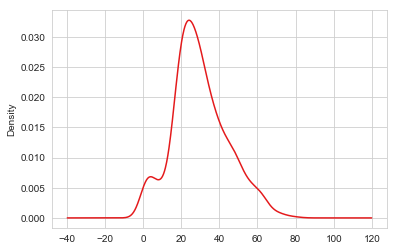

In [180]:
# 未缺失的年龄的大致分布
nona_data.plot(kind='kde')

In [181]:
nona_data.describe()

count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64

插值方式：
* Mr, Miss --> 21
* Mrs --> 28
* High --> 39

In [182]:
data = all_data.values
data.shape
len = data.shape[0]

(1309, 12)

In [183]:
for idx in range(len):
    tmp = data[idx, 2]
    if np.isnan(tmp):
        if data[idx, 12] == 1:
            data[idx, 2] = 39.
#         elif data[idx, 13] == 1 or data[idx, 14] == 1:
#             data[idx, 2] = 28.
        else:
            data[idx, 2] = 28.
    else:
        continue

In [184]:
all_data['Age'] = data[:, 2]

In [185]:
all_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0.0,2,1,2,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1.0,0,0,0,1,0,PC 17599,71.2833,C85,C,3
2,3,1.0,2,0,2,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1.0,0,0,0,1,0,113803,53.1000,C123,S,3
4,5,0.0,2,1,2,0,0,373450,8.0500,NaN,S,2


In [186]:
all_data.shape

(1309, 12)

In [187]:
any(all_data.Age.isna())

False

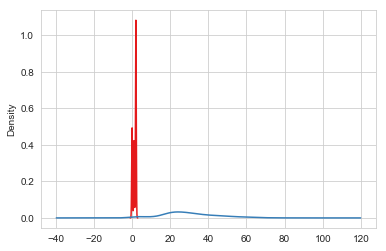

In [188]:
# 整体年龄的大致分布
all_data.Age.plot(kind='kde')
# 未缺失的年龄的大致分布
nona_data.plot(kind='kde')

### 3.5 Ticket

* Ticket 没有什么用处所以删除

In [189]:
all_data.drop(columns=['Ticket'], axis=1, inplace=True)

In [190]:
all_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,1,0.0,2,1,2,1,0,7.2500,NaN,S,2
1,2,1.0,0,0,0,1,0,71.2833,C85,C,3
2,3,1.0,2,0,2,0,0,7.9250,NaN,S,1
3,4,1.0,0,0,0,1,0,53.1000,C123,S,3
4,5,0.0,2,1,2,0,0,8.0500,NaN,S,2


In [191]:
all_data.shape

(1309, 11)

### 3.6 Cabin

In [192]:
nona = all_data.Cabin.count()
nona

295

In [193]:
num_na =all_data.shape[0] - nona
num_na

1014

缺失值太多，所以选择删除该列

In [194]:
all_data.drop(columns=['Cabin'], axis=1, inplace=True)

In [195]:
all_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0.0,2,1,2,1,0,7.2500,S,2
1,2,1.0,0,0,0,1,0,71.2833,C,3
2,3,1.0,2,0,2,0,0,7.9250,S,1
3,4,1.0,0,0,0,1,0,53.1000,S,3
4,5,0.0,2,1,2,0,0,8.0500,S,2


In [196]:
all_data.shape

(1309, 10)

### 3.7 Embarked

In [197]:
any(all_data.Embarked.isna())

True

In [198]:
nona = all_data.Embarked.count()
nona

1307

In [199]:
num_na =all_data.shape[0] - nona
num_na

2

In [200]:
all_data.Embarked.describe()

count     1307
unique       3
top          S
freq       914
Name: Embarked, dtype: object

* 使用众数进行插值
* one-hot编码

In [201]:
all_data.Embarked.fillna('S', inplace=True)
all_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0.0,2,1,2,1,0,7.2500,S,2
1,2,1.0,0,0,0,1,0,71.2833,C,3
2,3,1.0,2,0,2,0,0,7.9250,S,1
3,4,1.0,0,0,0,1,0,53.1000,S,3
4,5,0.0,2,1,2,0,0,8.0500,S,2


In [202]:
any(all_data.Embarked.isna())

False

In [203]:
# all_data = dummies('Embarked', all_data)
all_data['Embarked'] = le.fit_transform(all_data['Embarked'])

In [204]:
all_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0.0,2,1,2,1,0,7.2500,2,2
1,2,1.0,0,0,0,1,0,71.2833,0,3
2,3,1.0,2,0,2,0,0,7.9250,2,1
3,4,1.0,0,0,0,1,0,53.1000,2,3
4,5,0.0,2,1,2,0,0,8.0500,2,2


### 3.8 SibSp and Parch

* SibSp: 有误兄弟姐妹和配偶在船上
* Parch： 有无父母在船上
* 分别测试结果，发现分开两个特征效果会更好

In [205]:
any(all_data.SibSp.isna())
any(all_data.Parch.isna())

False

False

* 不存在空值
* 兄弟姐妹、配偶、父母都是家庭成员的一部分
* 如果船上有任意的家庭成员，那么其本人一定会优先考虑妻子老人或者小孩
* 使用二者的和作为新的特征

In [206]:
# all_data['Family'] = all_data['SibSp'] + all_data['Parch']  # 选择不合并的方式
all_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0.0,2,1,2,1,0,7.2500,2,2
1,2,1.0,0,0,0,1,0,71.2833,0,3
2,3,1.0,2,0,2,0,0,7.9250,2,1
3,4,1.0,0,0,0,1,0,53.1000,2,3
4,5,0.0,2,1,2,0,0,8.0500,2,2


In [207]:
# all_data.drop(columns=['SibSp', 'Parch'], axis=1, inplace=True)

In [208]:
all_data.head(10)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0.0,2,1,2,1,0,7.2500,2,2
1,2,1.0,0,0,0,1,0,71.2833,0,3
2,3,1.0,2,0,2,0,0,7.9250,2,1
3,4,1.0,0,0,0,1,0,53.1000,2,3
4,5,0.0,2,1,2,0,0,8.0500,2,2
5,6,0.0,2,1,2,0,0,8.4583,1,2
6,7,0.0,0,1,0,0,0,51.8625,2,2
7,8,0.0,2,1,2,3,1,21.0750,2,0
8,9,1.0,2,0,2,0,2,11.1333,2,3
9,10,1.0,1,0,1,1,0,30.0708,0,3


### 3.9 Fare

In [209]:
any(all_data.Fare.isna())

True

In [210]:
nona = all_data.Fare.count()
nona
num_na =all_data.shape[0] - nona
num_na

1308

1

In [211]:
all_data.Fare.describe()

count    1308.000000
mean       33.295479
std        51.758668
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

* 中值填充缺失值

In [212]:
all_data.Fare.fillna(15, inplace=True)

In [213]:
any(all_data.Fare.isna())

False

### 3.10 数据类型转换

In [214]:
all_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0.0,2,1,2,1,0,7.2500,2,2
1,2,1.0,0,0,0,1,0,71.2833,0,3
2,3,1.0,2,0,2,0,0,7.9250,2,1
3,4,1.0,0,0,0,1,0,53.1000,2,3
4,5,0.0,2,1,2,0,0,8.0500,2,2


In [215]:
all_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0.0,2,1,2,1,0,7.2500,2,2
1,2,1.0,0,0,0,1,0,71.2833,0,3
2,3,1.0,2,0,2,0,0,7.9250,2,1
3,4,1.0,0,0,0,1,0,53.1000,2,3
4,5,0.0,2,1,2,0,0,8.0500,2,2


In [216]:
all_data.Age = all_data.Age.apply(pd.to_numeric).astype('float32')

In [217]:
all_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0.0,2,1,2.0,1,0,7.2500,2,2
1,2,1.0,0,0,0.0,1,0,71.2833,0,3
2,3,1.0,2,0,2.0,0,0,7.9250,2,1
3,4,1.0,0,0,0.0,1,0,53.1000,2,3
4,5,0.0,2,1,2.0,0,0,8.0500,2,2


### 3.11 数据划分

* 重新划分训练街测试集并保存

In [218]:
train = all_data[:891]
test = all_data[-418:]
test = test.drop(columns=['Survived'], axis=1, inplace=False)

In [219]:
train.to_csv(f'{datadir}train_process.csv', index=False)
test.to_csv(f'{datadir}test_process.csv', index=False)

* 使用部分特征（丢掉与名字有关的特征）

In [220]:
all_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0.0,2,1,2.0,1,0,7.2500,2,2
1,2,1.0,0,0,0.0,1,0,71.2833,0,3
2,3,1.0,2,0,2.0,0,0,7.9250,2,1
3,4,1.0,0,0,0.0,1,0,53.1000,2,3
4,5,0.0,2,1,2.0,0,0,8.0500,2,2


In [221]:
# part_data = all_data.drop(columns=['High', 'Miss', 'Mr', 'Mrs', 'Other'], axis=1, inplace=False)
part_data.head()

NameError: name 'part_data' is not defined

In [ ]:
train1 = part_data[:891]
test1 = part_data[-418:]
test1 = test1.drop(columns=['Survived'], axis=1, inplace=False)

In [ ]:
train1.to_csv(f'{datadir}part_train_process.csv', index=False)
test1.to_csv(f'{datadir}part_test_process.csv', index=False)